<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/10/1012.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%%capture
!pip install igraph hdbscan kneed

## DBCV custom implementation

In [7]:
from itertools import combinations # to create a list containing unique pairs of cluster names

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_moons

from scipy.stats import multivariate_normal # for data set creation
from scipy.spatial.distance import pdist, squareform
import igraph as ig

import hdbscan
import hdbscan.validity
from kneed import KneeLocator

sns.set_theme()
plt.rcParams["image.cmap"] = "tab10"

### Create the  dataset

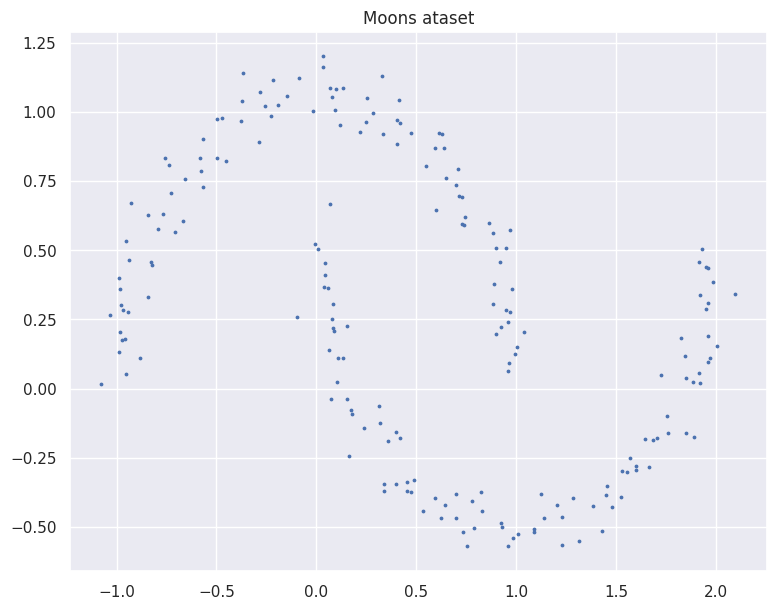

In [17]:
# Create moon dataset
X, y = make_moons(n_samples=200, shuffle=True, noise=0.06, random_state=12)
X[:,1][y==0] += 0.05 # todo_spencer: 不知為啥要把上半月提高 0.05

# Plot moon dataset
plt.figure(figsize=(9,7))
plt.scatter(X[:, 0], X[:, 1], s=3)
plt.title('Moons ataset')
plt.show()

In [18]:
# Cluster moons with k-means
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto')
kmeans = kmeans.fit(X)

In [19]:
CLR_DCT = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'yellow',
    -1:'black'
}

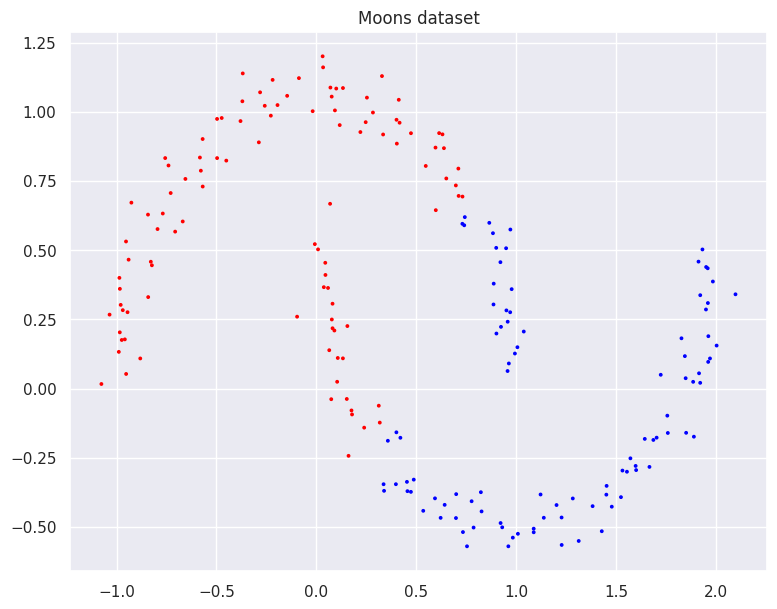

In [20]:
# Plot moon dataset
plt.figure(figsize=(9,7))
point_colors = [CLR_DCT[label] for label in kmeans.labels_]
plt.scatter(X[:, 0], X[:, 1], s=3, c=point_colors)
plt.title('Moons dataset')
plt.show()
# the k means does a bad job of clustering this data set

In [21]:
silhouette_score(X, kmeans.labels_) # despite that uh value of silhouette score is quite high

0.48316586739307915

In [ ]:
np.meshgrid([2,4,6], [2,4,6])

In [ ]:
pd.DataFrame(np.max(np.meshgrid([2,4,6], [2,4,6]), axis=0)) # 用於對所有 pairwise 的組合做運算

### DBCV


In [ ]:
# Get dbscan labels
labels = kmeans.labels_

# Choose metric
DIST_FUNCTION = "euclidean"
NUM_FEATURES = 2 # we will only need this if we use pre-computed
IGNORE_CORE = False # whether we want to skip calculating core distances and use original distances as mutual reachability distances.

# Check if distance function is precomputed
if DIST_FUNCTION == "precomputed":
    n_samples = np.shape(X)[0]
    n_features = NUM_FEATURES
    dists = X # pairwise distance matrix
else:
    n_samples = np.shape(X)[0]
    n_features = np.shape(X)[1]
    dists = pdist(X, DIST_FUNCTION)
    dists = squareform(dists)

In [ ]:
# Core distance calculation

# Array that will be used to store core distances
core_dists = np.empty(n_samples)

# Dict for cluster index
clust_point_dict = {} # (clsuter_index->datapoint_indice)

# Get all unique clusters except for the noise cluster
unique_clusts = list(np.unique(labels))
unique_clusts = [clust for clust in unique_clusts if clust!=-1]

if not IGNORE_CORE:
    # Iterate through unique labels - all calculations
    # in a single loop iteration correspond to single cluster
    for label in unique_clusts:
        # Get mask corresponding only to
        # datapoints from current cluster
        clust_ids = np.where(labels==label)[0] # data point indice

        # Add all cluster points to dict
        clust_point_dict[label] = clust_ids

        # Get number of points for cluster
        num_clust_points = clust_ids.shape[0]

        # Calculate core distances based on distances to
        # nearest neighbors
        clust_core_dists = dists[np.ix_(clust_ids, clust_ids)]
        clust_core_dists[clust_core_dists != 0] = np.power(
            clust_core_dists[clust_core_dists != 0],
            -n_features
        )
        clust_core_dists = np.sum(clust_core_dists, axis=1)/(num_clust_points - 1) # density estimates
        clust_core_dists = np.power(clust_core_dists, -1/n_features) # distance like measure

        # Store core dists
        core_dists[clust_ids] = clust_core_dists

    # Create mutual reachibility distance matrix
    max_core_dist = np.max(
        np.meshgrid(core_dists, core_dists),
        axis=0
    )
    mut_reach_dist = np.max(
        [dists, max_core_dist],
        axis=0
    )
else:
    for label in unique_clusts:
        clust_ids = np.where(labels==label)[0]

        clust_point_dict[label] = clust_ids

    mut_reach_dist = dists

In [ ]:
# Cluster density sparseness

# Dict to store density sparseness of a cluster
cluster_dens_spars = {} # (cluster_id->sparseness)

# Dict to store cluster internal nodes
cluster_internal_nodes = {} # (cluster_id->internal_node_indice)

# In this loop sparseness of a cluster and
# internal nodes are obtained
for label in unique_clusts:
    # Get index of all points from current cluster
    point_idx = clust_point_dict[label]

    # Get reachibility distances for points in
    # current cluster
    clust_mut_reach_dist = mut_reach_dist[np.ix_(point_idx, point_idx)].copy()
    np.fill_diagonal(clust_mut_reach_dist, 0) # todo_spencer: 為何要特地設為 0

    g = ig.Graph.Weighted_Adjacency(clust_mut_reach_dist, mode='undirected')

    # Find the minimum spanning tree
    mst = g.spanning_tree(weights=g.es["weight"])

    # we will transform the minimum spanning tree back into adjacency matrix and into a numpy array format
    mst_adj = mst.get_adjacency(attribute='weight')
    curr_MST = np.array(mst_adj.data)

    # find internal nodes and internal edges of the minimum spanning tree in order to find the backbone of the cluster

    # Calculate node degree
    node_degree = np.array((curr_MST>0).sum(axis=0)).flatten()

    # Find index of all internal nodes
    # (nodes with degree greater than 1)
    intern_sub_idx = np.where(node_degree>1)[0]

    # Max edge weight in MST is density sparseness of a cluster
    # Max edge is taken from set of internal edges
    cluster_dens_spars[label] = (curr_MST[np.ix_(intern_sub_idx,intern_sub_idx)]).max()

    # Collect all internal nodes of a cluster
    cluster_internal_nodes[label] = point_idx[intern_sub_idx]

In [ ]:
cluster_dens_spars

In [ ]:
# Cluster density separation

# Get all cluster pairs
clust_combs = list(combinations(unique_clusts, 2))

# Dataframe to store density separation
# between cluster pairs
distance_df = pd.DataFrame(
    np.full([len(unique_clusts), len(unique_clusts)], 0),
    index=unique_clusts,
    columns=unique_clusts)

# Calculate density separation for
# cluster pairs
for clust_comb in clust_combs:

    # Get cluster ids
    clust1 = clust_comb[0]
    clust2 = clust_comb[1]

    # Get cluster internal nodes
    clust1_points = cluster_internal_nodes[clust1]
    clust2_points = cluster_internal_nodes[clust2]

    # Minimum reachability between clsuter internal nodes
    # is cluster density separation
    curr_clust_sep = (mut_reach_dist[np.ix_(clust2_points, clust1_points)]).min()

    # Write distance to symetrical distance matrix
    distance_df.loc[clust1, clust2] = curr_clust_sep
    distance_df.loc[clust2, clust1] = curr_clust_sep


In [ ]:
distance_df

In [ ]:
# Calculate validity coefficient for all clusters
cluster_vc = {}

for label in unique_clusts:

    curr_vc_nom = distance_df[label].max() - cluster_dens_spars[label]
    curr_vc_den = max(distance_df[label].max(), cluster_dens_spars[label])

    cluster_vc[label] = curr_vc_nom/curr_vc_den


# Final calculation
final_res = 0

for label in unique_clusts:

    final_res +=  cluster_vc[label] * (clust_point_dict[label].shape[0]/n_samples)
    print('Validity index for cluster {} is {}'.format(label, cluster_vc[label]))

print('Mean validity index is {}'.format(final_res))

In [ ]:
# HDBSCAN libraru validity index
hdbscan.validity.validity_index(
    X=X,
    labels=kmeans.labels_,
    metric='euclidean',
    per_cluster_scores=True
)

In [ ]:
min_pts = X.shape[1] * 2

nbrs = NearestNeighbors(n_neighbors=min_pts).fit(X)
distances, _ = nbrs.kneighbors(X)

sort_dist = np.sort(distances[:,-1])

kneedle = KneeLocator(
    range(sort_dist.shape[0]),
    sort_dist,
    S=1.0,
    curve="convex",
    direction="increasing"
)
kneedle.plot_knee()

In [ ]:
dbscan = DBSCAN(eps=0.175, min_samples=4)
_ = dbscan.fit(X)


colors = [CLR_DCT[label] for label in dbscan.labels_]

plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], s=4, c=colors)
plt.title('K-means clustering')
plt.show()


In [ ]:
hdbscan.validity.validity_index(
    X=X,
    labels=dbscan.labels_,
    metric='euclidean',
    per_cluster_scores=True
)

## Parallel and long clusters

In [ ]:
# Create elongated clusters
multivar = multivariate_normal(cov = [[1, 0.98],[0.98,1]], mean = [1,1.5])
X1 = multivar.rvs(size = 500, random_state=1)

multivar = multivariate_normal(cov = [[1, 0.98],[0.98,1]], mean = [0.5,3])
X2 = multivar.rvs(size = 500, random_state=1)

X = np.vstack([X1, X2])

# Plot new clustering
plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.title('Dataset')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto')
kmeans.fit(X)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=20, c='red')
plt.title('Clustered dataset - K means')
plt.show()

In [ ]:
# Identify MinPts
min_pts = X.shape[1] * 2

# Find distances to min_pts'th neighbor
nbrs = NearestNeighbors(n_neighbors=min_pts).fit(X)
distances, _ = nbrs.kneighbors(X)

# Sort the distance to the min_pts'th neighbor
sort_dist = np.sort(distances[:,-1])

kneedle = KneeLocator(
    range(sort_dist.shape[0]),
    sort_dist,
    S=1.0,
    curve="convex",
    direction="increasing"
)
kneedle.plot_knee()

In [ ]:
# Cluster again
dbscan_tun = DBSCAN(eps=0.4, min_samples=min_pts)
_ = dbscan_tun.fit(X)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=dbscan_tun.labels_)
plt.title('Clustered dataset - DBSCAN after parameter tunning')
plt.show()

### Silouethe scores

In [ ]:
silhouette_score(X, kmeans.labels_)

In [ ]:
silhouette_score(X, dbscan_tun.labels_)

### DBCV values

In [ ]:
hdbscan.validity.validity_index(X, dbscan_tun.labels_, metric='euclidean', per_cluster_scores=True)

In [ ]:
hdbscan.validity.validity_index(X, kmeans.labels_, metric='euclidean', per_cluster_scores=True)